In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
import time
from tqdm import tqdm

class_labels = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z', 'del',
    'nothing', 'space'
]
num_classes = len(class_labels)
#set dir
dataset_dir = 'archive/asl_alphabet_train/asl_alphabet_train'
def process_image(img_path, label_index, hands):
    imageSize = 64
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = hands.process(img_rgb)
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                img_resized = cv2.resize(img_rgb, (imageSize, imageSize))
                img_normalized = img_resized / 255.0
                return (img_normalized, landmarks, label_index)
        else:
            return None
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None



Total images to process: 87000


  0%|                                                                                                    | 0/87000 [00:00<?, ?it/s]C:\Users\Thuan\AppData\Local\Programs\Python\Python39\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
100%|████████████████████████████████████████████████████████████████████████████████████████| 87000/87000 [37:50<00:00, 38.31it/s]


Data processing completed in 2271.03 seconds
Total samples collected: 63676
Processed data saved to 'processed_data.pkl'


In [ ]:
args_list = []
for label_index, label in enumerate(class_labels):
    class_dir = os.path.join(dataset_dir, label)
    if not os.path.isdir(class_dir):
        print(f"Directory not found: {class_dir}")
        continue
    img_names = os.listdir(class_dir)
    for img_name in img_names:
        img_path = os.path.join(class_dir, img_name)
        args_list.append((img_path, label_index))
print(f"Total images to process: {len(args_list)}")
start_time = time.time()
mp_hands = mp.solutions.hands
with mp_hands.Hands(static_image_mode=True, max_num_hands=1) as hands:
    results = []
    for args in tqdm(args_list):
        res = process_image(args[0], args[1], hands)
        results.append(res)
processed_data = [res for res in results if res is not None]
end_time = time.time()
print(f"Data processing completed in {end_time - start_time:.2f} seconds")
image_data = [item[0] for item in processed_data]
landmark_data = [item[1] for item in processed_data]
labels = [item[2] for item in processed_data]
print(f"Total samples collected: {len(labels)}")

In [ ]:
X_images = np.array(image_data, dtype=np.float32)
X_landmarks = np.array(landmark_data, dtype=np.float32)
y = np.array(labels)
y_encoded = to_categorical(y, num_classes)
with open('processed_data.pkl', 'wb') as f:
    pickle.dump((X_images, X_landmarks, y_encoded), f)
    print("Processed data saved to 'processed_data.pkl'")

In [19]:
import pickle
with open('processed_data.pkl', 'rb') as f:
    X_images, X_landmarks, y_encoded = pickle.load(f)
print("Processed data loaded successfully.")


Processed data loaded successfully.


In [4]:
from sklearn.model_selection import train_test_split
X_train_img, X_test_img, X_train_landmarks, X_test_landmarks, y_train, y_test = train_test_split(
    X_images, X_landmarks, y_encoded, test_size=0.2, random_state=42)

print("Data split into training and testing sets.")


Data split into training and testing sets.


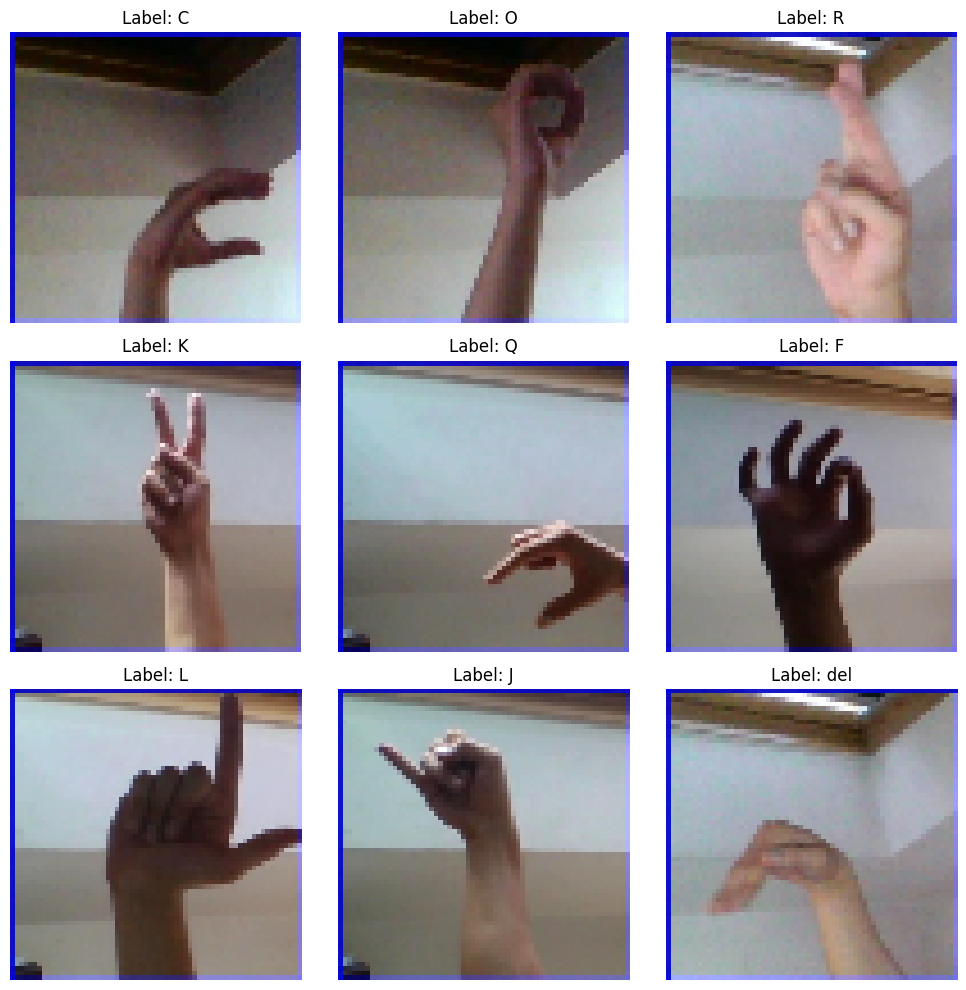

In [7]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 9 
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_img[i])
    plt.title(f"Label: {class_labels[np.argmax(y_train[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.optimizers import Adam

image_input = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

num_landmarks = 21 * 3 
landmark_input = Input(shape=(num_landmarks,))
y = Dense(128, activation='relu')(landmark_input)
y = Dropout(0.5)(y)
y = Dense(64, activation='relu')(y)

combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(len(class_labels), activation='softmax')(z)
model = Model(inputs=[image_input, landmark_input], outputs=z)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel summary:")
model.summary()



Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 62, 62, 32)        │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 31, 31, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 63)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 29, 29, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           8,192 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 14, 14, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 12544)             │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 12608)             │               0 │ flatten[0][0],             │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │       1,613,952 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 29)                │           3,741 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,653,533 (6.31 MB)

 Trainable params: 1,653,533 (6.31 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
history = model.fit(
    [X_train_img, X_train_landmarks],
    y_train,
    validation_data=([X_test_img, X_test_landmarks], y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.2436 - loss: 2.5685 - val_accuracy: 0.9389 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.7933 - loss: 0.6055 - val_accuracy: 0.9711 - val_loss: 0.1281 - learning_rate: 0.0010
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.8804 - loss: 0.3499 - val_accuracy: 0.9856 - val_loss: 0.0718 - learning_rate: 0.0010
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9136 - loss: 0.2541 - val_accuracy: 0.9892 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.9282 - loss: 0.2020 - val_accuracy: 0.9913 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 42s 52ms/step - accuracy: 0.9365 - loss: 0.1736 - val_accuracy: 0.9932 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.9452 - l

In [10]:
test_loss, test_accuracy = model.evaluate(
    [X_test_img, X_test_landmarks], y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9967 - loss: 0.0147

Test Loss: 0.0127
Test Accuracy: 0.9975


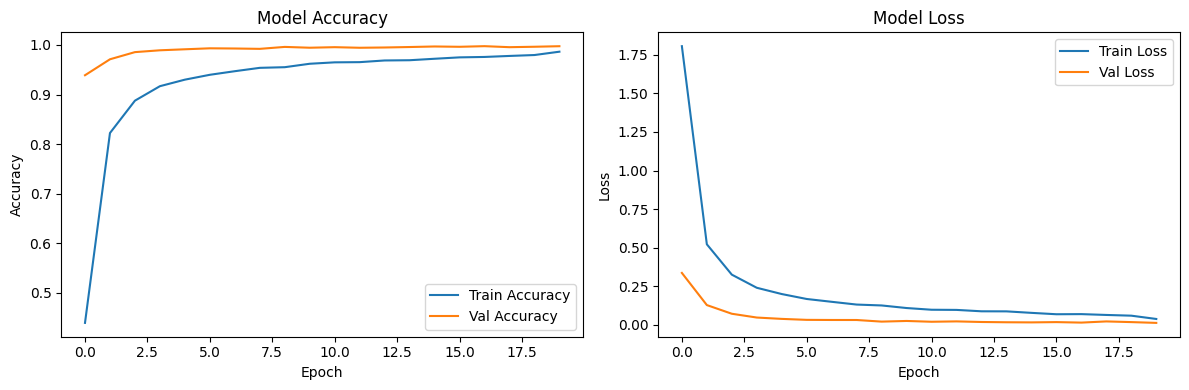

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [14]:
predictions = model.predict([X_test_img, X_test_landmarks])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
print("Predictions made on the test set.")

398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Predictions made on the test set.


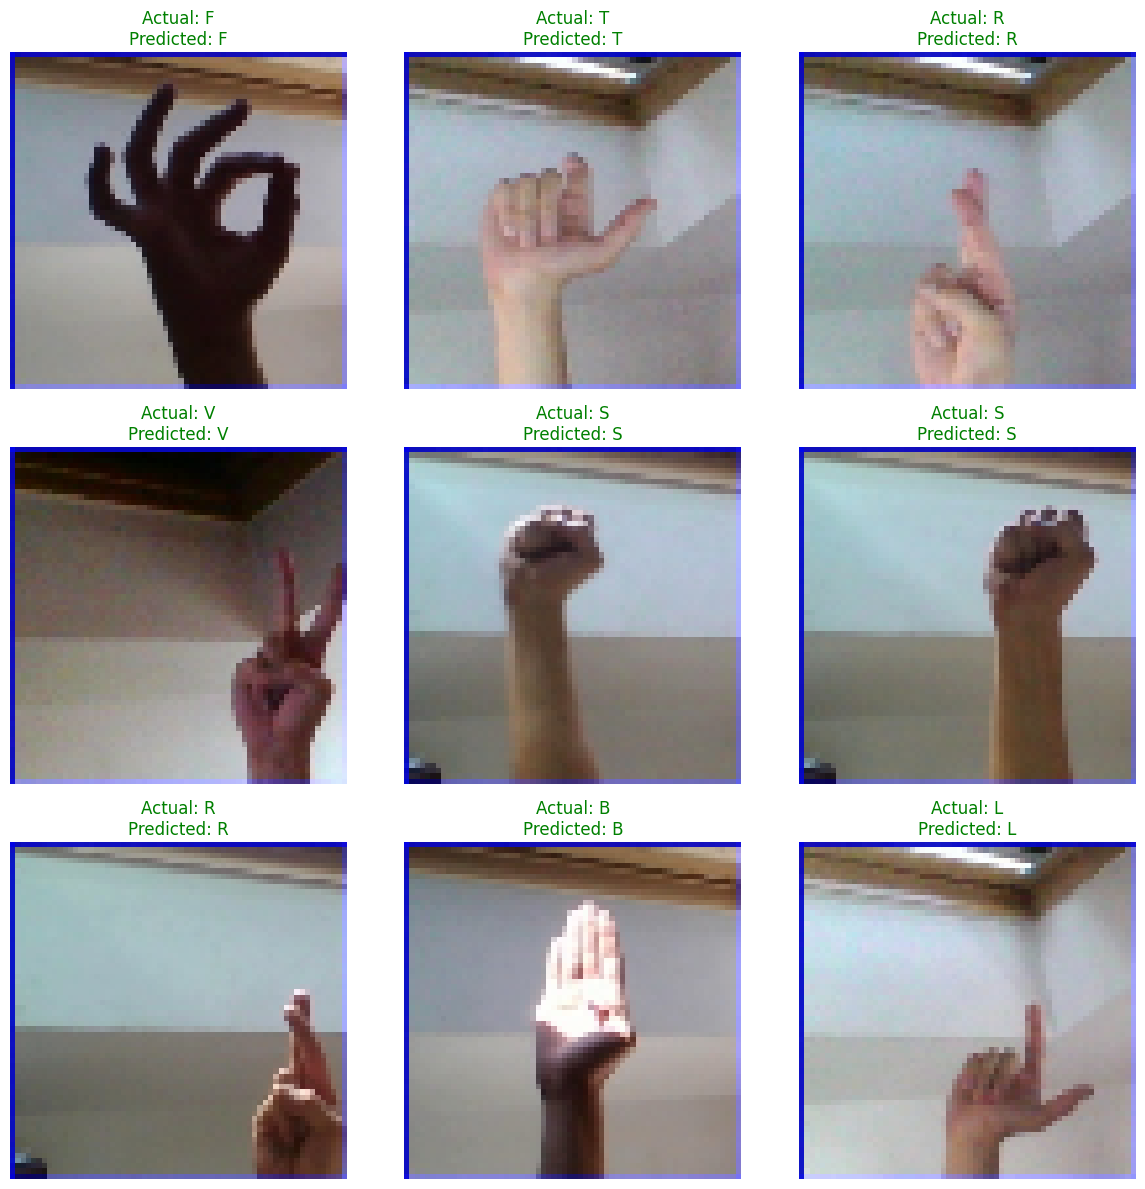

In [16]:
plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(3, 3, i+1)
    img = X_test_img[i]
    plt.imshow(img)
    true_label = class_labels[true_classes[i]]
    predicted_label = class_labels[predicted_classes[i]]    
    if predicted_label == true_label:
        title_color = 'green'
    else:
        title_color = 'red'
    plt.title(f"Actual: {true_label}\nPredicted: {predicted_label}", color=title_color, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
model.save('asl_combined_model.h5')
print("Model saved as 'asl_combined_model.h5'.")

Model saved as 'asl_combined_model.h5'.
